In [2]:
import operator

from langchain_core.messages import HumanMessage
from lang_graph.assistant.shared_models import InterviewState, ResearchGraphState,SearchQueryState,Questions, Analysts
from config import EXA_API_KEY
from config import set_environment
from IPython.core.display import Image
from langgraph.constants import END, START
from langgraph.graph import  StateGraph
from langchain_mistralai import ChatMistralAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import  SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langgraph.types import Send
from langchain_exa import ExaSearchRetriever

In [3]:
set_environment()

In [4]:
import os
key = os.getenv("MISTRAL_API_KEY")
print(f"Key exists: {key is not None}")

Key exists: True


In [5]:
llm = ChatMistralAI(model = "mistral-small-latest")

In [6]:
create_analyst_prompt = ("You are given the task of creating AI analysts with different personas. Here are the instructions. Follow them carefully."
"1. You are given a research topic. Topic: {topic}."
"2. You are also given human feedback for analysts you created. Incorporate the feedback and further refine the analysts. Human Feedback: {human_feedback}"
"3. Decide on the most interesting themes based on the topic and the human feedback."
"4. Pick the top {max_analysts} themes."
"5. Assign one analyst to each of the theme based on their role and organization.")

In [7]:
interview_prmpt = """You are an analyst researching on the topic '{topic}'. You have a assigned role and organization. Here are the details about your persona and goals. {goals}.
 You are tasked with interviewing an expert to learn about the topic. 
 Follow these instructions while interviewing:
 1. Ask a specific and an insightful question about the topic. The question should be non-obvious that people will find exciting. 
 2. Avoid generalized or common questions.
 3. After receiving the expert answer, continue to ask further questions and drill down the expert to get a better understanding of the topic. 
 4. Once you are satisfied,complete the interview. 
 5. Throughout the interview stay in your character and persona and ask only those questions that aligns with your persona."""

generate_question_prmpt = """Below is the conversation between an analyst and an expert. 
Conversation: {conversation}
Your task is to refine the conversation into a set of {num_question} queries. These queries should be well-structured and be suitable for retrieving from wikipedia and / or web-search. Follow the below instructions.
 1. Analyse the full conversation.
 2. Pay particular attention to the question posed by the analyst.
 3. Convert the question posed by the analyst into a set of {num_question} web-search and arxiv retrieval queries.
 4. Break down composite questions into single-issue questions that are direct.
 5. Ask only one thing at a time suitable for web-search and wikipedia."""

generate_answer_prmpt = """You are an expert in the topic '{topic}'. Your task is to answer a set of  questions posed based on the given context. 
Questions: {questions}, Context: {context}. 
When answering the questions, follow these instructions.
1. Use only the provided context to answer the questions.
2. Do not introduce any other external information and do not make any assumptions other than those explicitly given in the context.
3. The context contains urls of the sources at the top of each document.
4. Include the sources in the answer next to any relevant statements. For example source 1 should be included as [1].
5.List your sources in order at the end of your answer. For example: [1] Source 1, [2] Source 2 etc.
6. If the source is: <Document href="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document href preamble in your citation."""

generate_section_prmpt = """You are an expert technical writer.
 You are given a topic and an area of focus within the topic.
 You are also given a set of questions and a set of relevant documents that answers the question.
Topic: {topic} , Area of focus: {focus}.
Your task is to create a section of the report from a set of source documents.
1. Create a report structure using the markdown formatting
- Use ## for the section title
- Use ### for sub-section headers.
2. Make you title engaging based on the question.
3. Each document has a title and a source given by href at the beginning.
4. For the summary section, 
- Start the summary with general background or context related to the question.
- Emphasize what is novel, interesting, or surprising about insights gathered from the documents
- Do not mention the names of the analysts or the experts
- Create a numbered list of source documents, as you use them
- Aim for approximately 300 words minimum and a maximum of 400 words.
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents.
5. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

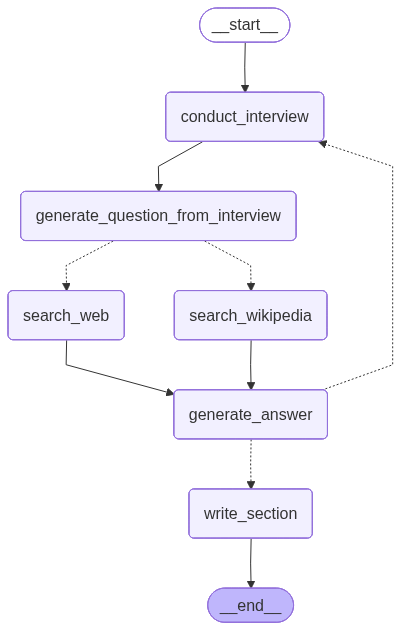

In [9]:
def conduct_interview(state: InterviewState):
    print(f"conducting interviews on {state.topic}")
    persona = f"Name: {state.analyst.name}, role: {state.analyst.role}, organization: {state.analyst.organization}, description: {state.analyst.description}"
    prmpt = interview_prmpt.format(goals=persona, topic=state.topic)
    # prmpt = question_prmpt.format(goals=persona)
    if len(state.conversations) != 0:
        human_message = HumanMessage(
            content = f"Here are the past interviews with the expert. Interview: {state.conversations}"
        )
        conversations = llm.invoke([SystemMessage(content=prmpt)] + [human_message])
    else:
        print(f"invoking llm for interview")
        conversations = llm.invoke([SystemMessage(content=prmpt)])
        print(f"returned response : {conversations.content}")
    return {"conversations": [conversations.content]}
    
def generate_question_from_interview(state: InterviewState):
    prmpt = generate_question_prmpt.format(conversation=state.conversations, num_question=state.num_questions)
    response = llm.with_structured_output(Questions).invoke(prmpt)
    print(f"questions generated: {response.questions}")
    return {"questions": response.questions}

def fetch_answer_content(state: InterviewState):
    # return [Send("search_web", SearchQueryState(query=q)) for q in state.questions]
    web_results = [Send("search_web", SearchQueryState(query=q)) 
                   for q in state.questions[-state.num_questions:]]
    wikipedia_results = [Send("search_wikipedia", SearchQueryState(query=q)) 
                         for q in state.questions[-state.num_questions:]]
    return web_results + wikipedia_results
    
def search_web(state: SearchQueryState):
    exa = ExaSearchRetriever(
    apikey=EXA_API_KEY,
    k=2,
    summary=True, 
    text_contents_options={"max_characters": 3000}  
    )
    search_results = exa.invoke(state.query)
    combined_docs = "".join(
         f'<Document href="{doc.metadata["url"]}">\n'
         f'Question: {state.query}\n\n '
         f'Answer:\n Title: {doc.metadata["title"]}\n'
         f'Summary: {doc.metadata["summary"]}\n</Document>'
        for doc in search_results
    )
    return {"search_results": [combined_docs]}

def search_wikipedia(state: SearchQueryState):
    wikipedia_docs = WikipediaLoader(query=state.query, load_max_docs=2).load()
    formatted_search_docs = "".join(
        [
            f'<Document href="{doc.metadata["source"]}">\n'
            f'Question: {state.query}\n\n '
             f'Answer:\n Title: {doc.metadata["title"]}\n'
            f'Summary: {doc.metadata["summary"]}\n</Document>'
            for doc in wikipedia_docs
        ]
    )
    return {"search_results": [formatted_search_docs]}

def generate_answer(state: InterviewState):
    persona = f"Name: {state.analyst.name}, role: {state.analyst.role}, organization: {state.analyst.organization}, description: {state.analyst.description}"
    topic = state.topic
    context = state.search_results
    prmpt = generate_answer_prmpt.format(topic=topic, context=context, questions=state.questions)
    answer = llm.invoke([SystemMessage(content=prmpt)])
    answer.name = "expert"
    return {"answer": [answer.content]}
    
def route_messages(state: InterviewState):
    if len(state.answer) < 2:
        return "conduct_interview"
    else:
        return "write_section"

def write_section(state: InterviewState):
    prmpt = generate_section_prmpt.format(topic=state.topic, focus=state.analyst.description)
    human_message = HumanMessage(
        content = f"Use the below content to write the section in the report. Questions: {state.questions}"
                  f"Content : {state.search_results}"
    )
    response = llm.invoke([SystemMessage(content=prmpt), human_message])
    return {"section": [response.content]}   
    

interview_builder = StateGraph(InterviewState)
interview_builder = interview_builder.add_node("conduct_interview", conduct_interview)
interview_builder = interview_builder.add_node("generate_question_from_interview", generate_question_from_interview)
interview_builder = interview_builder.add_node("search_web", search_web)
interview_builder = interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder = interview_builder.add_node("generate_answer", generate_answer)
interview_builder = interview_builder.add_node("write_section", write_section)

interview_builder = interview_builder.add_edge(START, "conduct_interview")
interview_builder = interview_builder.add_edge("conduct_interview", "generate_question_from_interview")
interview_builder = interview_builder.add_conditional_edges("generate_question_from_interview", fetch_answer_content, ["search_web", "search_wikipedia"])
interview_builder = interview_builder.add_edge("search_web", "generate_answer")
interview_builder = interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder = interview_builder.add_conditional_edges("generate_answer", route_messages, ["conduct_interview","write_section"])
interview_builder = interview_builder.add_edge("write_section", END)
interview_graph = interview_builder.compile()
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [10]:

    
write_report_prmpt = """You are an expert technical writer. You are given section about a topic written by {max_analysts} analysts.
Below is the topic and the sections written by analysts.
Topic: {topic}, Sections: {section}
Your task is to combine these sections into one coherent report. Follow the below instructions
1. Write a compelling introduction on why this report matters. 
2. Write a conclusion that summarizes the key points in the sections.
3. Each section has sources at the end. Combine these sources into one single source and add it to the end of the report.
4. Do not include any external information. Use only the information provided in the sections.
"""

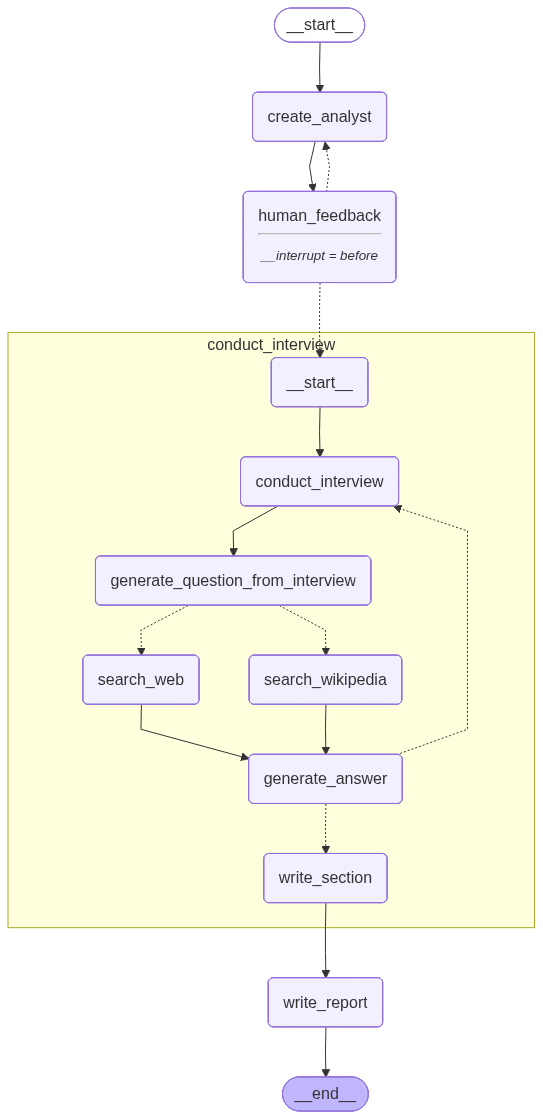

In [24]:

    
def write_report(state: ResearchGraphState):
    prmpt = write_report_prmpt.format(max_analysts=state.max_analysts, topic = state.topic, section = state.section)
    response = llm.invoke([SystemMessage(content=prmpt)])
    return {"report": [response.content]}

def human_feedback(state: ResearchGraphState):
    pass

def create_analyst(state: ResearchGraphState):
    prmpt = create_analyst_prompt.format(topic=state.topic, human_feedback=state.human_feedback, max_analysts=state.max_analysts)
    results = llm.with_structured_output(Analysts).invoke(prmpt)
    if state.human_feedback is not None:
        state.human_feedback = None
    return {"analysts": results.analysts}
    
def initiate_all_interviews(state: ResearchGraphState):
    print(f"Initiating interviews for {state.human_feedback}")
    if state.human_feedback is not None and state.human_feedback != "":
        print(f"create_analyst")
        return "create_analyst"
    else:
        print(f"Initiating interviews={state.analysts}")
        return [Send("conduct_interview", 
                     InterviewState(
                         topic=state.topic, 
                         num_questions=state.num_questions,
                         analyst=analyst, 
                         conversations=[],
                         questions=[],
                         section="",
                     )) for analyst in state.analysts]

research_graph_builder = StateGraph(ResearchGraphState)
research_graph_builder = research_graph_builder.add_node("create_analyst", create_analyst)
research_graph_builder = research_graph_builder.add_node("human_feedback", human_feedback)
research_graph_builder = research_graph_builder.add_node("conduct_interview", interview_builder.compile())
research_graph_builder = research_graph_builder.add_node("write_report", write_report)

research_graph_builder = research_graph_builder.add_edge(START, "create_analyst")
research_graph_builder = research_graph_builder.add_edge("create_analyst", "human_feedback")
research_graph_builder = research_graph_builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analyst", "conduct_interview"])
research_graph_builder = research_graph_builder.add_edge("conduct_interview", "write_report")
research_graph_builder = research_graph_builder.add_edge("write_report", END)
checkpointer = MemorySaver()
research_graph = research_graph_builder.compile(interrupt_before=["human_feedback"],checkpointer=checkpointer)
display(Image(research_graph.get_graph(xray=1).draw_mermaid_png()))

In [25]:
config = {"configurable": {"thread_id": 1}}
# result = research_graph.invoke(ResearchGraphState(topic="Effect of LLM in student learning"), config=config)
# result

for event in research_graph.stream(
        ResearchGraphState(
            topic="Effect of LLM in student learning", 
            max_analysts=3,
            num_questions=2
        ), config=config, stream_mode="values"):
    print(event)

{'max_analysts': 3, 'topic': 'Effect of LLM in student learning', 'analysts': [], 'num_questions': 2, 'section': []}
{'max_analysts': 3, 'topic': 'Effect of LLM in student learning', 'analysts': [Analyst(name='Dr. Sarah Chen', organization='Educational Technology Institute', role='Senior Researcher', description='Dr. Chen specializes in the intersection of technology and education. She has extensive experience in studying the impact of various educational tools on student performance.'), Analyst(name='Professor James Wilson', organization='Harvard University', role='Professor of Cognitive Psychology', description='Professor Wilson focuses on cognitive development and learning processes. He has published numerous papers on how different teaching methods affect student learning outcomes.'), Analyst(name='Dr. Lisa Thompson', organization='Stanford University', role='Assistant Professor of Education', description="Dr. Thompson's research centers on the integration of AI in educational sett

In [26]:
state = research_graph.get_state(config=config).next
state

('human_feedback',)

In [27]:
research_graph.update_state(config=config, values={"human_feedback": "Add a cognitive scientist"}, as_node="human_feedback")
result = research_graph.invoke(None, config=config)
result

Initiating interviews for Add a cognitive scientist
create_analyst


{'max_analysts': 3,
 'topic': 'Effect of LLM in student learning',
 'human_feedback': 'Add a cognitive scientist',
 'analysts': [Analyst(name='Dr. Sarah Johnson', organization='Cognitive Science Institute', role='Cognitive Scientist', description='Dr. Sarah Johnson specializes in the cognitive processes involved in learning and memory. She has extensive experience in studying how technology impacts learning outcomes.'),
  Analyst(name='Dr. Michael Chen', organization='Educational Technology Research Center', role='Educational Technologist', description='Dr. Michael Chen focuses on integrating technology into educational practices. He has published numerous papers on the impact of AI and machine learning in education.'),
  Analyst(name='Dr. Lisa Thompson', organization='Institute for Learning Analytics', role='Learning Analyst', description='Dr. Lisa Thompson specializes in learning analytics and data-driven approaches to education. She has worked on several projects analyzing the effec

In [28]:
state = research_graph.get_state(config=config).next
state

('human_feedback',)

In [29]:
research_graph.update_state(config=config, values={"human_feedback": None}, as_node="human_feedback")
final_state = research_graph.invoke(None, config=config)
print(final_state["report"])

Initiating interviews for None
Initiating interviews=[Analyst(name='Dr. Sarah Johnson', organization='Cognitive Science Institute', role='Cognitive Scientist', description='Dr. Sarah Johnson specializes in the cognitive processes involved in learning and memory. She has extensive experience in studying how technology impacts learning outcomes.'), Analyst(name='Dr. Michael Chen', organization='Educational Technology Research Center', role='Educational Technologist', description='Dr. Michael Chen focuses on integrating technology into educational practices. He has published numerous papers on the impact of AI and machine learning in education.'), Analyst(name='Dr. Lisa Thompson', organization='Institute for Learning Analytics', role='Learning Analyst', description='Dr. Lisa Thompson specializes in learning analytics and data-driven approaches to education. She has worked on several projects analyzing the effectiveness of different educational tools and techniques.')]
conducting interview

HTTPStatusError: Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}

In [30]:
state = research_graph.get_state(config=config).next
state

('conduct_interview',)

In [31]:
final_state = research_graph.invoke(None, config=config)
print(final_state["report"])

['# The Transformative Impact of Large Language Models on Student Learning\n\n## Introduction\n\nThe rapid advancement of large language models (LLMs) has ushered in a new era in education, reshaping how students learn, engage with material, and develop critical thinking skills. As educational institutions increasingly integrate AI-driven tools into their curricula, understanding the profound effects of LLMs on student learning becomes paramount. This report explores the multifaceted influence of LLMs, from enhancing metacognitive processes and self-regulated learning to fostering interdisciplinary collaboration and uncovering unexpected benefits. By examining these dimensions, we aim to provide educators, policymakers, and students with a comprehensive understanding of how LLMs are revolutionizing education and what this means for the future of learning.\n\n## Unlocking Metacognition: How LLMs Transform Student Learning\n\n### The Metacognitive Edge of LLMs\n\nThe integration of large

In [32]:
final_state.keys()

dict_keys(['max_analysts', 'topic', 'human_feedback', 'analysts', 'num_questions', 'section', 'report'])

In [35]:
len(final_state["section"])

3

In [33]:
for section in final_state["section"]:
    print(f"Section: {section}")
    print(f"{'='*50}")

Section: ## Unlocking Metacognition: How LLMs Transform Student Learning

### The Metacognitive Edge of LLMs

The integration of large language models (LLMs) into educational settings has sparked significant interest in their potential to enhance students' metacognitive processes, particularly in self-regulation and self-monitoring of learning. Traditional study methods often rely on static resources and passive engagement, whereas LLMs offer dynamic, interactive, and personalized learning experiences. This shift has profound implications for how students approach, monitor, and regulate their learning journeys.

One of the most compelling findings is that LLMs can significantly enhance students' self-reflective practices. Through personalized feedback and prompts, LLMs encourage students to critically evaluate their learning strategies and outcomes. This interaction fosters a deeper understanding of their own cognitive processes, enabling them to better assess their comprehension and a

In [34]:
final_state["report"]

['# The Transformative Impact of Large Language Models on Student Learning\n\n## Introduction\n\nThe rapid advancement of large language models (LLMs) has ushered in a new era in education, reshaping how students learn, engage with material, and develop critical thinking skills. As educational institutions increasingly integrate AI-driven tools into their curricula, understanding the profound effects of LLMs on student learning becomes paramount. This report explores the multifaceted influence of LLMs, from enhancing metacognitive processes and self-regulated learning to fostering interdisciplinary collaboration and uncovering unexpected benefits. By examining these dimensions, we aim to provide educators, policymakers, and students with a comprehensive understanding of how LLMs are revolutionizing education and what this means for the future of learning.\n\n## Unlocking Metacognition: How LLMs Transform Student Learning\n\n### The Metacognitive Edge of LLMs\n\nThe integration of large